### Edgar Moises Hernandez-Gonzalez
#### 19/02/20-25/03/20
#### Clasificacion de imagenes motoras en EEG con CNN-2D + LSTM, CNN-2D + GRU y ConvLSTM2D
##### Caracteristicas = Espectrogramas STFFT (3D)
##### 5 ejecuciones independientes

#### CNN-2D + LSTM
##### Sujeto 1
##### Accuracy = 57.99%
##### Kappa = 0.4398

#### CNN-2D + LSTM BN
##### Sujeto 1
##### Accuracy = 50.69%
##### Kappa = 0.3426

#### CNN-2D + GRU
##### Sujeto 1
##### Accuracy = 57.99%
##### Kappa = 0.4398

#### CNN-2D + GRU BN
##### Sujeto 1
##### Accuracy = 52.08%
##### Kappa = 0.3611

#### ConvLSTM2D
##### Sujeto 1
##### Accuracy = 63.19%
##### Kappa = 0.5093

#### ConvLSTM2D BN
##### Sujeto 1
##### Accuracy = 55.21%
##### Kappa = 0.4028

In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import cohen_kappa_score, confusion_matrix
from scipy.signal import spectrogram
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPool2D, Flatten, Dense, Dropout,
                                     TimeDistributed, LSTM, GRU, ConvLSTM2D,
                                     BatchNormalization, Activation)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

In [ ]:
# para que este script funcione debe de decir 'channels_last', si dice 'channels_first' no sirve
K.image_data_format()

'channels_last'

In [ ]:
x_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/MI-EEG-A01T.csv", header=None)
x_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/MI-EEG-A01E.csv", header=None)
y_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/EtiquetasA01T.csv", header=None)
y_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/EtiquetasA01E.csv", header=None)

In [ ]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(288, 22000)
(288, 22000)
(288, 1)
(288, 1)


In [ ]:
n_samples_train = len(y_train)
n_samples_test = len(y_test) #en caso de no tener el y_test se puede utilizar el x_test

print("n_samples_train:", n_samples_train)
print("n_samples_test :", n_samples_test)

n_samples_train: 288
n_samples_test : 288


In [ ]:
n_classes = len(np.unique(y_test)) #esto se podria calcular asi n_clases = len(np.unique(y)), la y puede ser train o test

print("n_classes:", n_classes)

n_classes: 4


In [ ]:
#codificar etiquetas con valores de 0 a nClases-1
le = LabelEncoder().fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
#unir 22 canales
def unir_espectrogramas_horizontal(data):
  fs = 250
  datos = np.zeros((288,24,88))
  temporal = np.zeros((24,88))
  for i in range(data.shape[0]): #288 muestras
    for j in range(22): #22 canales
      sig = data.iloc[i, j*1000:(j+1)*1000]
      f, t, Sxx = spectrogram(sig, fs) #espectrograma de STFFT
      temporal[:, j*4:(j+1)*4] = Sxx[8:32, :]
    datos[i] = temporal
  return datos

In [ ]:
#llamar a unir_espectrogramas_horizontal(data, fs)
x_train = unir_espectrogramas_horizontal(x_train)
x_test = unir_espectrogramas_horizontal(x_test)

In [ ]:
print(x_train.shape)
print(x_test.shape)

(288, 24, 88)
(288, 24, 88)


In [ ]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))

127.36705810165053
103.14882408038861
3.3899630126531786e-07
5.741129212423684e-07


In [ ]:
#convertir a float
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#escalar los valores en un rango de 0 a 1 (normalizar)
x_train /= 128.0
x_test /= 128.0

In [ ]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))

0.99505514
0.8058502
2.6484086e-09
4.485257e-09


In [ ]:
#convertir de 3D a 5D
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1], x_train.shape[2], 1))
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1], x_test.shape[2], 1))

print(x_train.shape)
print(x_test.shape)

(288, 1, 24, 88, 1)
(288, 1, 24, 88, 1)


In [ ]:
'''def CNN_2D_LSTM_TD():
  model = Sequential()
  model.add(TimeDistributed(Conv2D(32, (3,3), activation='relu', padding='same'),
                            input_shape=x_train.shape[1:]))
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(32))
  model.add(Dropout(0.2))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-5)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model'''

In [ ]:
'''def CNN_2D_LSTM_TD_BN():
  model = Sequential()
  model.add(TimeDistributed(Conv2D(32, (3,3), padding='same'),
                            input_shape=x_train.shape[1:]))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(Activation('relu')))
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(32))
  model.add(BatchNormalization()) #la activacion antes de BN porque es tanh
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-4)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model'''

In [ ]:
'''def CNN_2D_GRU_TD():
  model = Sequential()
  model.add(TimeDistributed(Conv2D(32, (3,3), activation='relu', padding='same'),
                            input_shape=x_train.shape[1:]))
  model.add(TimeDistributed(Flatten()))
  model.add(GRU(64))
  model.add(Dropout(0.2))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-5)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model'''

In [ ]:
'''def CNN_2D_GRU_TD_BN():
  model = Sequential()
  model.add(TimeDistributed(Conv2D(32, (3,3), padding='same'),
                            input_shape=x_train.shape[1:]))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(Activation('relu')))
  model.add(TimeDistributed(Flatten()))
  model.add(GRU(64))
  model.add(BatchNormalization()) #la activacion antes de BN porque es tanh
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-5)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model'''

In [ ]:
def Conv_LSTM_2D():
  model = Sequential()
  model.add(ConvLSTM2D(32, (3,3), activation='relu', padding='same',
                       input_shape=x_train.shape[1:]))
  model.add(Flatten())
  model.add(Dense(64, activation='relu'))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-4)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model

In [ ]:
'''def Conv_LSTM_2D_BN():
  model = Sequential()
  model.add(ConvLSTM2D(32, (3,3), padding='same',
                       input_shape=x_train.shape[1:]))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Flatten())
  model.add(Dense(64))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-6)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model'''

Iteration: 1
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
288/288 - 0s - loss: 1.3806 - acc: 0.6076
kappa:  0.47685185185185186
f1: 0.6091295217794019
confusion matrix:
 [[43 16  9  4]
 [17 44  9  2]
 [ 2  2 47 21]
 [ 5  1 25 41]]


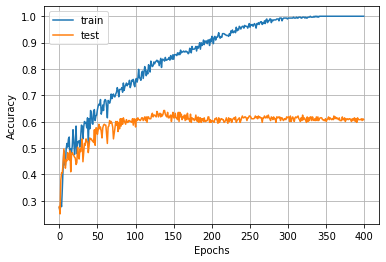

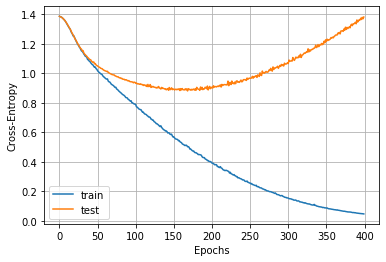

Iteration: 2
288/288 - 0s - loss: 1.5726 - acc: 0.5938
kappa:  0.45833333333333337
f1: 0.5952888300956949
confusion matrix:
 [[40 16 11  5]
 [17 44  9  2]
 [ 2  3 47 20]
 [ 3  2 27 40]]


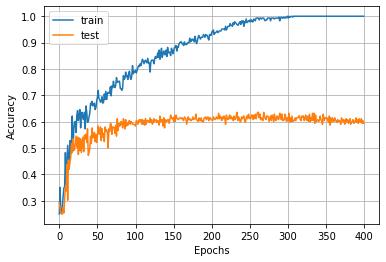

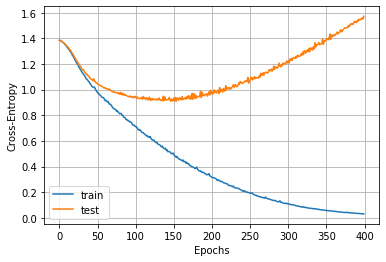

Iteration: 3
288/288 - 0s - loss: 1.5463 - acc: 0.6111
kappa:  0.4814814814814815
f1: 0.6115400326797386
confusion matrix:
 [[47 14  7  4]
 [18 45  7  2]
 [ 1  3 47 21]
 [ 6  2 27 37]]


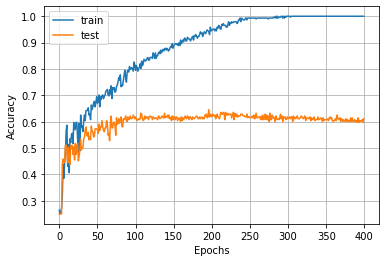

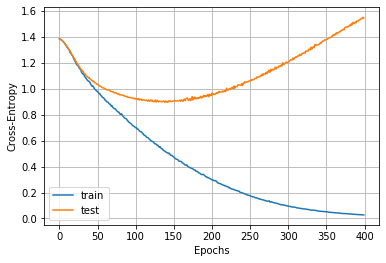

Iteration: 4
288/288 - 0s - loss: 1.4857 - acc: 0.6076
kappa:  0.47685185185185186
f1: 0.6088242940426727
confusion matrix:
 [[49 13  5  5]
 [19 41 11  1]
 [ 4  3 44 21]
 [ 3  2 26 41]]


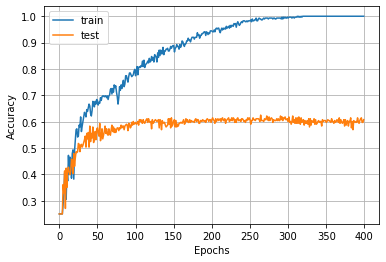

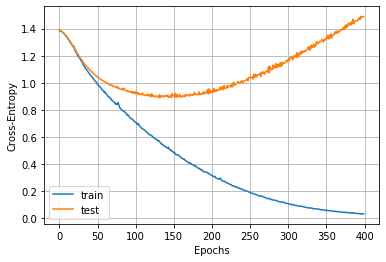

Iteration: 5
288/288 - 0s - loss: 1.5702 - acc: 0.6215
kappa:  0.49537037037037035
f1: 0.6224876472936508
confusion matrix:
 [[48 13  6  5]
 [19 42 10  1]
 [ 2  3 47 20]
 [ 5  1 24 42]]


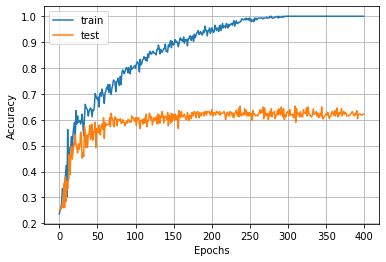

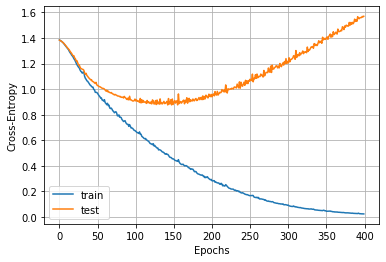


Resultados:
loss: [1.3805530203713312, 1.5725975698894925, 1.5463039080301921, 1.4857071903016832, 1.5702003770404391]
accuracy: [0.6076389, 0.59375, 0.6111111, 0.6076389, 0.6215278]
kappa: [0.47685185185185186, 0.45833333333333337, 0.4814814814814815, 0.47685185185185186, 0.49537037037037035]
f1: [0.6091295217794019, 0.5952888300956949, 0.6115400326797386, 0.6088242940426727, 0.6224876472936508]


In [ ]:
array_loss = []
array_acc = []
array_kappa = []
for i in range(5):
  print("Iteration:", i+1)
    
  #model = CNN_2D_LSTM_TD()
  #model = CNN_2D_LSTM_TD_BN()
  #model = CNN_2D_GRU_TD()
  #model = CNN_2D_GRU_TD_BN()
  model = Conv_LSTM_2D()
  #model = Conv_LSTM_2D_BN()

  history = model.fit(x_train, y_train, epochs=400, batch_size=18,
                      validation_data=(x_test, y_test), verbose=0)
    
  test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
  array_loss.append(test_loss)
  array_acc.append(test_acc)
    
  probabilidades = model.predict(x_test)
  y_pred = np.argmax(probabilidades, 1) #1=fila
    
  kappa = cohen_kappa_score(y_test, y_pred)
  array_kappa.append(kappa)
  print("kappa: ", kappa)
    
  matriz_confusion = confusion_matrix(y_test, y_pred)
  print("confusion matrix:\n", matriz_confusion)
    
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'test'])
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Cross-Entropy')
  plt.legend(['train', 'test'])
  plt.show()
    
print() 
print("Resultados:")
print("loss:", array_loss)
print("accuracy:", array_acc)
print("kappa:", array_kappa)

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_4 (ConvLSTM2D)  (None, 24, 88, 32)        38144     
_________________________________________________________________
flatten_4 (Flatten)          (None, 67584)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4325440   
_________________________________________________________________
dense_9 (Dense)              (None, 4)                 260       
Total params: 4,363,844
Trainable params: 4,363,844
Non-trainable params: 0
_________________________________________________________________


In [ ]:
print("Mean Accuracy: %.4f" % np.mean(array_acc))
print("std: (+/- %.4f)" % np.std(array_acc))
print("Mean Kappa: %.4f" % np.mean(array_kappa))
print("std: (+/- %.4f)" % np.std(array_kappa))
print("Max Accuracy: %.4f" % np.max(array_acc))
print("Max Kappa: %.4f" % np.max(array_kappa))

Mean Accuracy: 0.6083
std: (+/- 0.0089)
Mean Kappa: 0.4778
std: (+/- 0.0119)
Mean F1: 0.6095
Max Accuracy: 0.6215
Max Kappa: 0.4954
Max F1: 0.6225
